### Outliers Detection algorithm


We need to create an algorithm that can find outliers in this data by one column / several columns. E.g. some members have extremely high costs in the current month and the solution should be able to detect such records

All financial columns contain $ sign

Columns:
- member_unique_id - member's ID	
- gender - member's gender
- dob - member's date of birth
- eligible_year - year
- eligible_month - month
- affiliation_type - doctor's type
- pbp_group - health plan group
- plan_name - health plan name
- npi - doctor's ID
- line_of_business - health plan type
- esrd - True if patient is on dialysis
- hospice - True if patient is in hospice


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
def del_dollar(dollar):
    return float(dollar.replace("$","").replace(",",""))

In [3]:
def z_outs(serie):
    outs = []
    for s in serie: 
        z = (s-serie.mean())/serie.std()
        if z > 3: 
            outs.append(s)
    if len(outs)>0:
        print(round((len(outs)/len(serie)), 2)*100, '%')
    return min(outs)

In [4]:
def robust_z_outs(serie):
    outs=[]
    for s in serie: 
        z = (0.6745*(s-serie.median()))/(stats.median_absolute_deviation(serie))
        if z > 3: 
            outs.append(s)
    if len(outs)>0:
        print(round((len(outs)/len(serie)), 2)*100, '%')
    return(min(outs))

In [5]:
def iqr_outs(serie):
    outs = []
    for s in serie:
        iqr = serie.quantile(0.75)-serie.quantile(0.25)
        up_tail = serie.quantile(0.75) + 1.5*iqr
        if s > up_tail:
            outs.append(s)
    if len(outs)>0:
        print(round((len(outs)/len(serie)), 2)*100, '%')
    return min(outs)

## 1. Data load & preview

In [6]:
data = pd.read_csv('sfr_test.csv', index_col='member_unique_id')
data.shape

(10530, 27)

In [7]:
data.head()

,gender,dob,eligible_year,eligible_month,affiliation_type,pbp_group,plan_name,npi,line_of_business,esrd,...,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
member_unique_id,,,,,,,,,,,,,,,,,,,,,
1,F,21/06/1990,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,1,HMO,False,...,$0.00,"$3,507.00",$0.00,$7.92,$0.00,$0.00,$0.00,$0.00,$0.00,$843.78
2,M,02/01/1948,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,False,...,$0.00,"$6,204.84",$0.00,$8.13,$0.00,"$11,289.69",$0.00,"$10,688.46","$10,859.82",$906.77
3,M,14/06/1948,2020,202006,Affiliate,NON-SNP,MEDICARE - CAREFREE,1,HMO,False,...,$0.00,"$4,012.46",$0.00,$7.92,$0.00,$0.00,$0.00,$0.00,$0.00,$815.84
4,M,10/02/1954,2020,202006,Affiliate,D-SNP,MEDICARE - CARENEEDS,1,HMO,False,...,$0.00,"$9,770.61",$0.00,$8.30,$0.00,$73.88,$0.00,$62.87,$64.91,$846.26
5,M,31/12/1953,2020,202006,Affiliate,NON-SNP,NaN,1,HMO,False,...,$0.00,"$19,976.13","$8,875.80",$8.90,$0.00,$522.48,$0.00,$517.56,$606.01,$867.55


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10530 entries, 1 to 10530
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   gender               10530 non-null  object
 1   dob                  10530 non-null  object
 2   eligible_year        10530 non-null  int64 
 3   eligible_month       10530 non-null  int64 
 4   affiliation_type     10530 non-null  object
 5   pbp_group            10530 non-null  object
 6   plan_name            6606 non-null   object
 7   npi                  10530 non-null  int64 
 8   line_of_business     10530 non-null  object
 9   esrd                 10530 non-null  bool  
 10  hospice              10530 non-null  bool  
 11  ipa_funding          10530 non-null  object
 12  ma_premium           10530 non-null  object
 13  ma_risk_score        10530 non-null  object
 14  mbr_with_rx_rebates  10530 non-null  object
 15  partd_premium        10530 non-null  object
 16  pcp_

Since we have the date of birth and the current date, let's add an age column. Suddenly we need it.

### Add age

In [9]:
data['year_born'] = pd.to_datetime(data['dob']).dt.year
data['age'] = data['eligible_year'] - data['year_born']

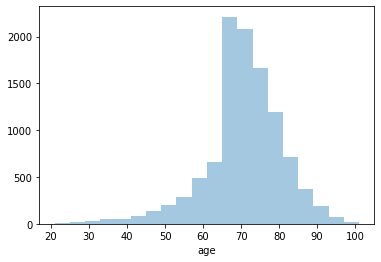

In [10]:
# age distribution
sns.distplot(data['age'], kde=False, bins=20);

Basic and simple solution to this problem is to search for outliers within each column with one of the conventional methods (z-statistics, robust z-statistics, IQR method, isolated forest). But it is also worth considering that financial indicators may have a different distribution depending on other factors, and in this case it makes sense to identify outliers by segment. 

So, first, we need to analyze the relationship between categorical and financial features.

## 2. Categorical features

Let's designate categorical features and visualize them using countplots.

In [11]:
cat_features = list(data.iloc[:, :11].columns)
cat_features.remove('dob')
cat_features.remove('npi')
print('Categorical features:\n', cat_features)

Categorical features:
 ['gender', 'eligible_year', 'eligible_month', 'affiliation_type', 'pbp_group', 'plan_name', 'line_of_business', 'esrd', 'hospice']


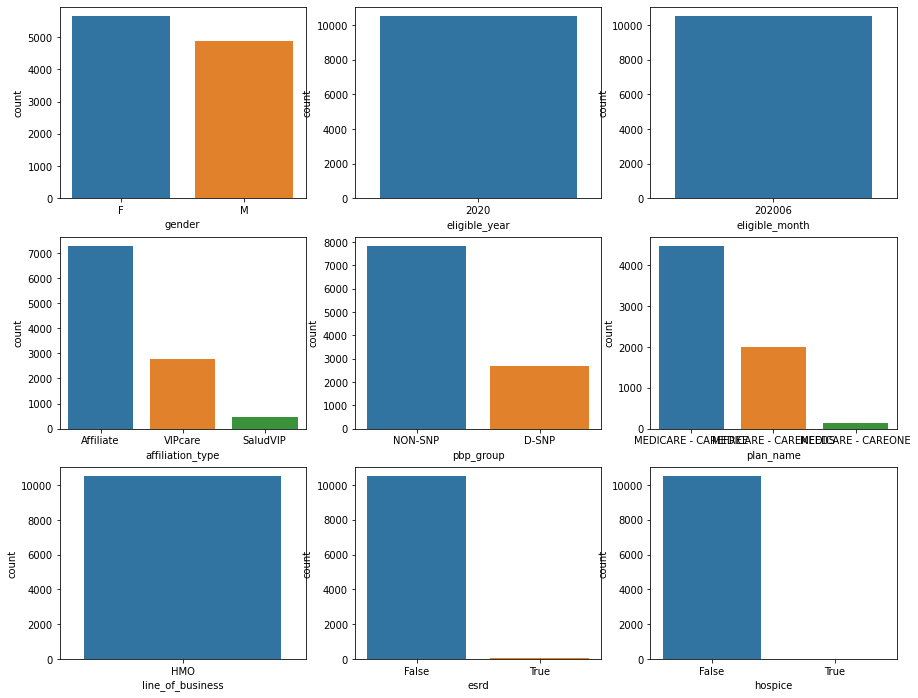

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
for idx, feature in enumerate(cat_features):
    sns.countplot(data[cat_features][feature], ax=axes[idx //3, idx % 3]);

In [13]:
data['esrd'].value_counts()

False    10503
True        27
Name: esrd, dtype: int64

In [14]:
data['hospice'].value_counts()

False    10511
True        19
Name: hospice, dtype: int64

Let's remove constant features.

In [15]:
drops_cat = ['eligible_year', 'eligible_month', 'line_of_business']
for x in drops_cat:
    cat_features.remove(x)
print('Final categorical features:\n', cat_features)

Final categorical features:
 ['gender', 'affiliation_type', 'pbp_group', 'plan_name', 'esrd', 'hospice']


## 3. Finance feaures

Let's mark for all finance_features the features containing the $ sign and make the transformation.

In [16]:
finance_features = list(data.iloc[:, 11:27].columns)
print('Finanace features:\n', finance_features)

Finanace features:
 ['ipa_funding', 'ma_premium', 'ma_risk_score', 'mbr_with_rx_rebates', 'partd_premium', 'pcp_cap', 'pcp_ffs', 'plan_premium', 'prof', 'reinsurance', 'risk_score_partd', 'rx', 'rx_rebates', 'rx_with_rebates', 'rx_without_rebates', 'spec_cap']


In [17]:
data[finance_features].head()

,ipa_funding,ma_premium,ma_risk_score,mbr_with_rx_rebates,partd_premium,pcp_cap,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
member_unique_id,,,,,,,,,,,,,,,,
1,"$2,721.85","$3,611.21",$2.02,$632.13,$82.13,$474.83,$0.00,"$3,507.00",$0.00,$7.92,$0.00,$0.00,$0.00,$0.00,$0.00,$843.78
2,"$5,060.21","$6,817.97",$5.24,"$2,535.98",$205.93,$457.04,$0.00,"$6,204.84",$0.00,$8.13,$0.00,"$11,289.69",$0.00,"$10,688.46","$10,859.82",$906.77
3,"$3,159.82","$3,443.32",$3.17,$595.96,$59.13,$482.63,$0.00,"$4,012.46",$0.00,$7.92,$0.00,$0.00,$0.00,$0.00,$0.00,$815.84
4,"$9,563.23","$11,015.31",$9.92,$181.95,$265.65,$469.04,$0.00,"$9,770.61",$0.00,$8.30,$0.00,$73.88,$0.00,$62.87,$64.91,$846.26
5,"$17,456.26","$17,590.58",$25.55,$810.83,$210.62,$527.98,$0.00,"$19,976.13","$8,875.80",$8.90,$0.00,$522.48,$0.00,$517.56,$606.01,$867.55


In [18]:
for feature in finance_features:
    data[feature] = data[feature].apply(del_dollar)
    data[feature] = pd.to_numeric(data[feature], errors='coerce')

In [19]:
data[finance_features].head()

,ipa_funding,ma_premium,ma_risk_score,mbr_with_rx_rebates,partd_premium,pcp_cap,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
member_unique_id,,,,,,,,,,,,,,,,
1,2721.85,3611.21,2.02,632.13,82.13,474.83,0.0,3507.00,0.0,7.92,0.0,0.00,0.0,0.00,0.00,843.78
2,5060.21,6817.97,5.24,2535.98,205.93,457.04,0.0,6204.84,0.0,8.13,0.0,11289.69,0.0,10688.46,10859.82,906.77
3,3159.82,3443.32,3.17,595.96,59.13,482.63,0.0,4012.46,0.0,7.92,0.0,0.00,0.0,0.00,0.00,815.84
4,9563.23,11015.31,9.92,181.95,265.65,469.04,0.0,9770.61,0.0,8.30,0.0,73.88,0.0,62.87,64.91,846.26
5,17456.26,17590.58,25.55,810.83,210.62,527.98,0.0,19976.13,8875.8,8.90,0.0,522.48,0.0,517.56,606.01,867.55


In [20]:
data[finance_features].describe()

,ipa_funding,ma_premium,ma_risk_score,mbr_with_rx_rebates,partd_premium,pcp_cap,pcp_ffs,plan_premium,prof,reinsurance,risk_score_partd,rx,rx_rebates,rx_with_rebates,rx_without_rebates,spec_cap
count,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.000000,10530.0,10530.000000,10530.0,10530.000000,10530.000000,10530.000000
mean,10657.849594,12311.727551,14.601082,500.425354,281.523642,507.875923,44.715122,12622.875903,407.262296,8.728322,0.0,2166.888445,0.0,2177.164111,2177.391484,811.940253
std,7690.191694,8955.579076,11.398322,1130.533796,239.155174,269.436836,279.992983,9165.144567,1787.161653,0.505910,0.0,13570.047143,0.0,13867.469329,13775.436097,134.976209
min,1302.360000,1394.850000,0.000000,13.940000,8.620000,0.000000,0.000000,1295.180000,0.000000,7.910000,0.0,0.000000,0.0,0.000000,0.000000,578.320000
25%,5390.645000,6200.255000,6.502500,197.210000,130.780000,503.020000,0.000000,6362.810000,0.000000,8.290000,0.0,0.000000,0.0,0.000000,0.000000,711.512500
50%,8723.135000,10060.455000,11.740000,312.365000,220.590000,613.500000,0.000000,10317.105000,0.000000,8.690000,0.0,114.205000,0.0,115.150000,115.110000,775.110000
75%,13444.632500,15479.840000,18.920000,499.352500,352.032500,684.260000,0.000000,15886.765000,0.000000,9.160000,0.0,536.537500,0.0,536.535000,536.355000,890.310000
max,113850.930000,155112.650000,174.600000,32687.500000,3120.530000,833.330000,6056.440000,138352.500000,69516.960000,9.670000,0.0,557883.960000,0.0,570037.030000,588346.570000,1329.520000


As we can see from the description, there are 2 constant features, as well as features with a large number of zeros. Let's see what is the proportion of zeros in finance_features:

In [21]:
# Calculate the proportion of zeros in finance_features:
for feature in finance_features:
    print(feature, '   ',   (data[feature][data[feature]==0]).shape[0]/data.shape[0])

ipa_funding     0.0
ma_premium     0.0
ma_risk_score     0.0013295346628679962
mbr_with_rx_rebates     0.0
partd_premium     0.0
pcp_cap     0.20721747388414055
pcp_ffs     0.9603988603988604
plan_premium     0.0
prof     0.824596391263058
reinsurance     0.0
risk_score_partd     1.0
rx     0.33409306742640077
rx_rebates     1.0
rx_with_rebates     0.33409306742640077
rx_without_rebates     0.33409306742640077
spec_cap     0.0


We will remove only constant features.

In [22]:
drops_finance = ['risk_score_partd', 'rx_rebates']
for x in drops_finance:
    finance_features.remove(x)
print('Final finanace features:\n', finance_features)

Final finanace features:
 ['ipa_funding', 'ma_premium', 'ma_risk_score', 'mbr_with_rx_rebates', 'partd_premium', 'pcp_cap', 'pcp_ffs', 'plan_premium', 'prof', 'reinsurance', 'rx', 'rx_with_rebates', 'rx_without_rebates', 'spec_cap']


Let's build boxplots of the remaining features and their distribution histograms without zero values. We will accept the hypothesis that zero values are the absence of costs for the current month for this item (perhaps this is due to the absence of some services).

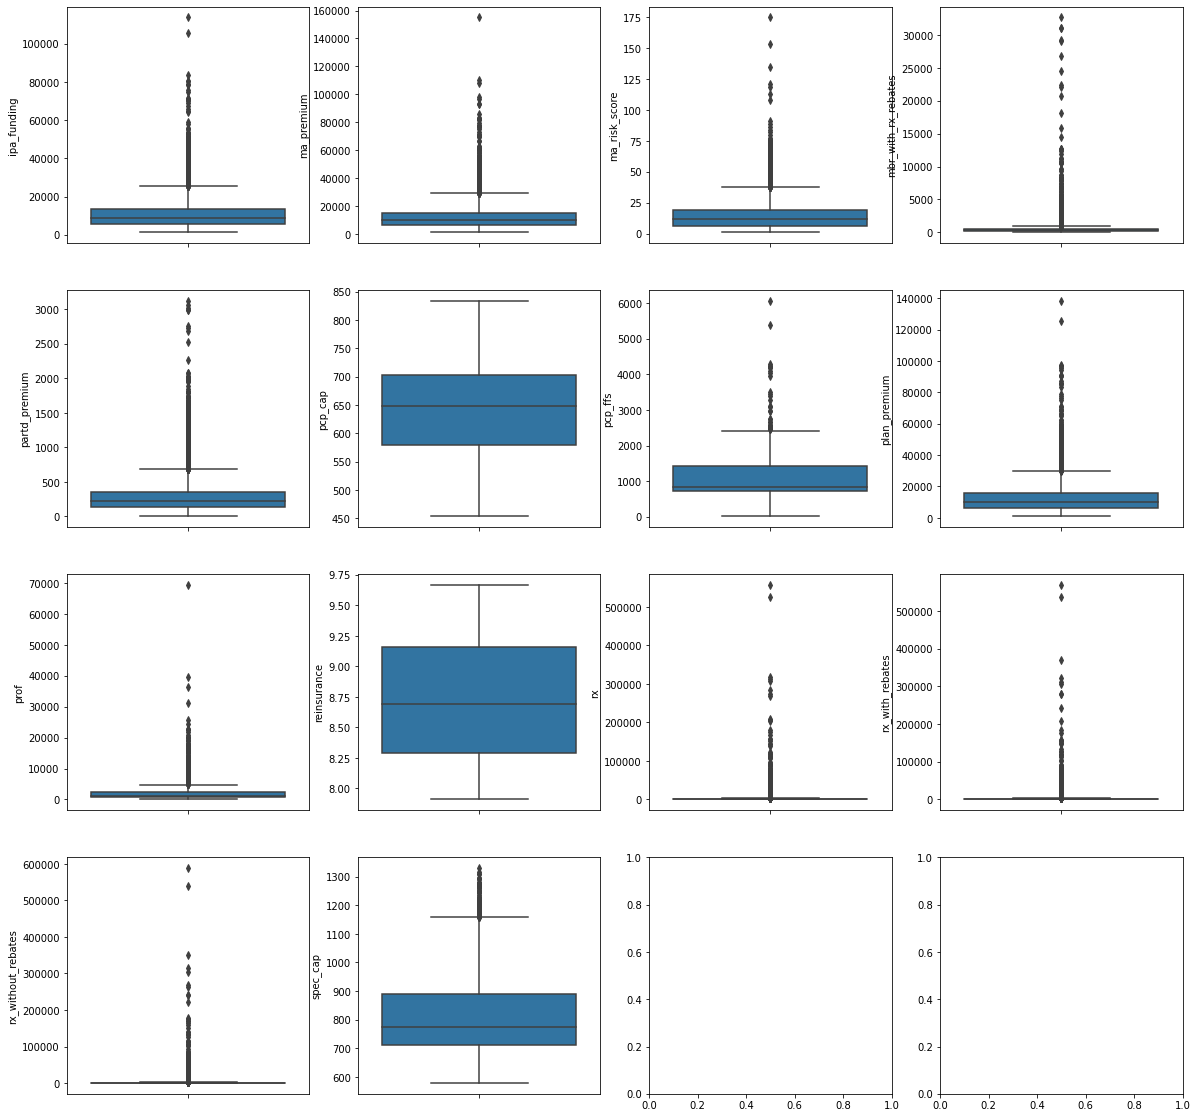

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
for idx, feature in enumerate(finance_features):
    sns.boxplot(y=data[data[feature]!=0][feature], orient='v',ax=axes[idx //4, idx % 4]);

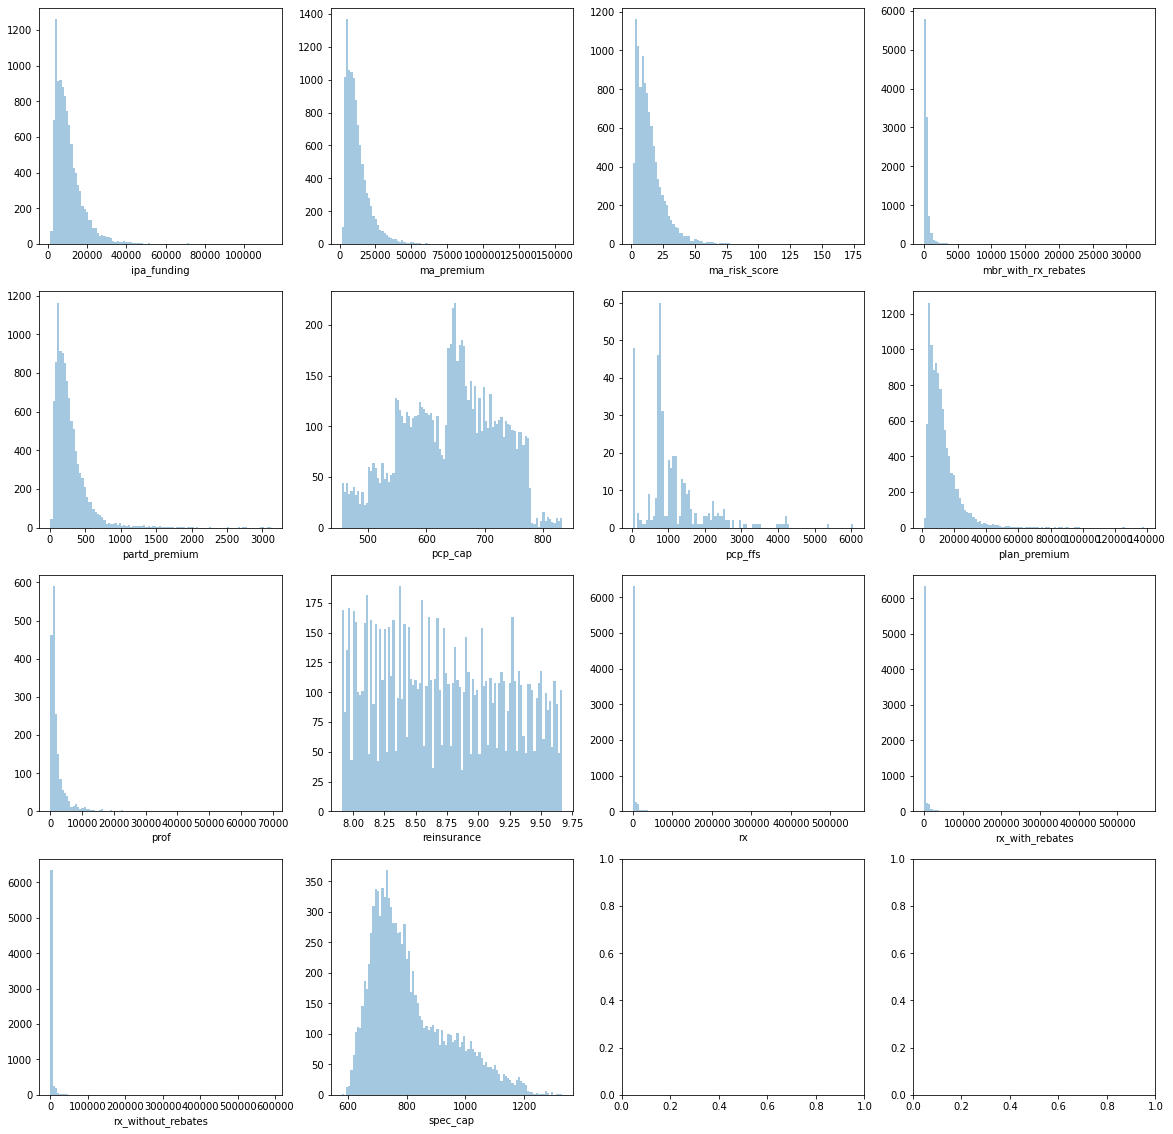

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
for idx, feature in enumerate(finance_features):
    sns.distplot(data[data[feature]!=0][feature],kde=False, bins=100, ax=axes[idx //4, idx % 4]);

As can be seen from the diagrams, the distribution of most features is very skewed. To remove the right "tail" we will try some conventional methods and choose the most optimal one.

First of all, let's segment financial_features across all cat_features to make sure there is no strong bias in financial_features depending on any cat_features. We will also check if age affects any of the financial indicators. Let's build a scatterplot for this.


## 4. Finance features analysis

### age vs. finance features

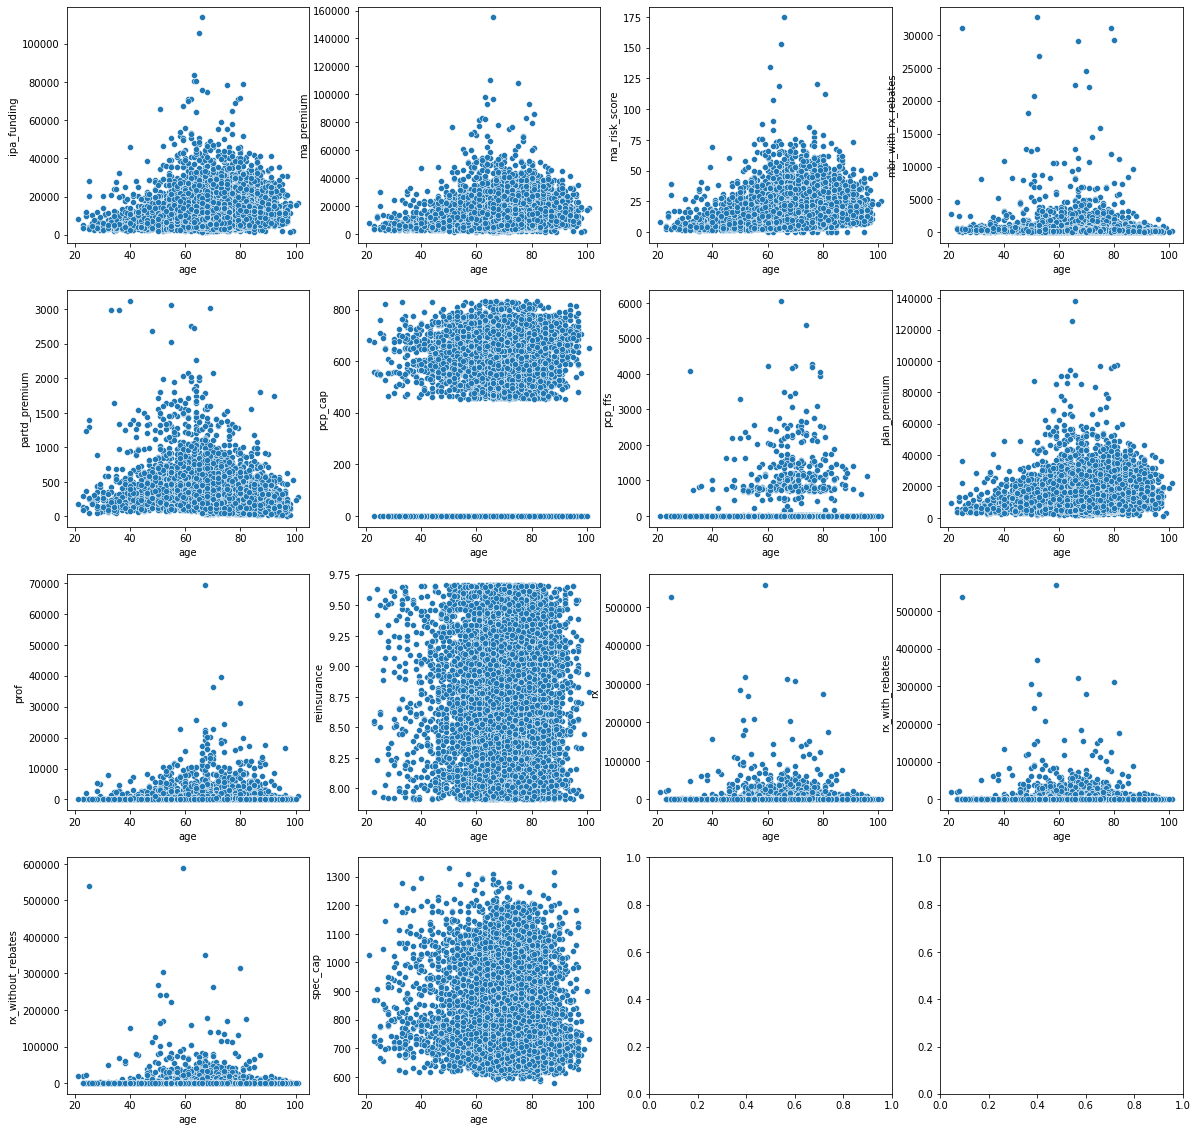

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
for idx, feature in enumerate(finance_features):
    sns.scatterplot(data['age'], data[feature], ax=axes[idx//4, idx %4]);

Based on scatterplots, there is no correlation between age and any of the financial indicators. We don't need 'age' feature then.

Let's build boxplots for evaluating financial performance by category.

### 4.1. ipa_funding

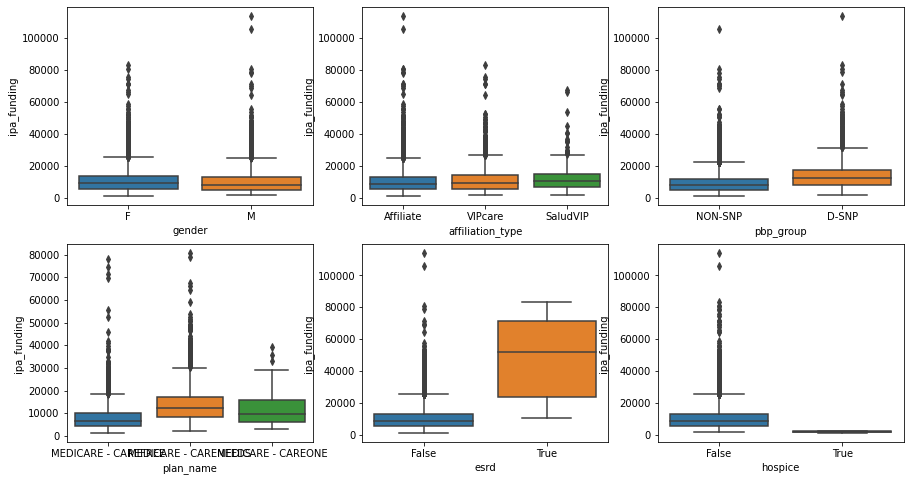

In [26]:
finance_feature = 'ipa_funding'

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for idx, feature in enumerate(cat_features):
    sns.boxplot(x=data[feature], y=data[finance_feature], ax=axes[idx //3, idx % 3]);

The diagram shows that the distribution of ipa_funding differs significantly in the case when the patient is on dialysis. Let's check this statistically using the Student's t test for 2 independent samples.

**ipa_funding vs. esrd**

H0: mean_esrd_true = mean_esrd_false

H1: mean_esrd_true != mean_esrd_false

In [27]:
stats.ttest_ind\
(data[data['esrd']  == True]['ipa_funding'], data[data['esrd']  == False]['ipa_funding'], equal_var = False)

Ttest_indResult(statistic=7.882472051028649, pvalue=2.3245792585986805e-08)

p << 0.05, therefore, the hypothesis of equality of means is not confirmed. That is, it is better to detect outliers for each segment separately.

### 4.2. ma_premium

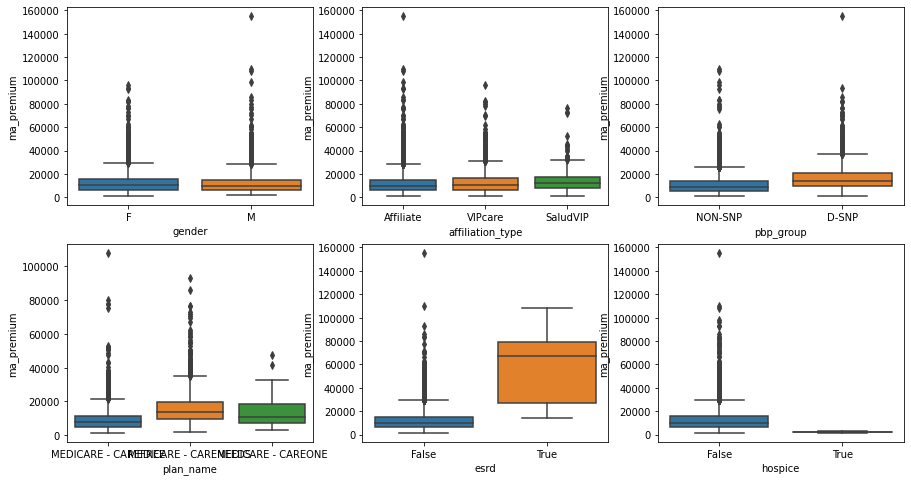

In [28]:
finance_feature = 'ma_premium'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for idx, feature in enumerate(cat_features):
    sns.boxplot(x=data[feature], y=data[finance_feature], ax=axes[idx //3, idx % 3]);

Similar pattern. Perhaps these indicators are correlated, but this is not important to us in this case. We will proceed as in the previous case.

**ma_premium vs. esrd**

In [29]:
stats.ttest_ind\
(data[data['esrd']  == True]['ma_premium'], data[data['esrd']  == False]['ma_premium'], equal_var = False)

Ttest_indResult(statistic=7.734566442702667, pvalue=3.301167596023932e-08)

The hypothesis of equality of means is also not confirmed.

### 4.3. ma_risk_score

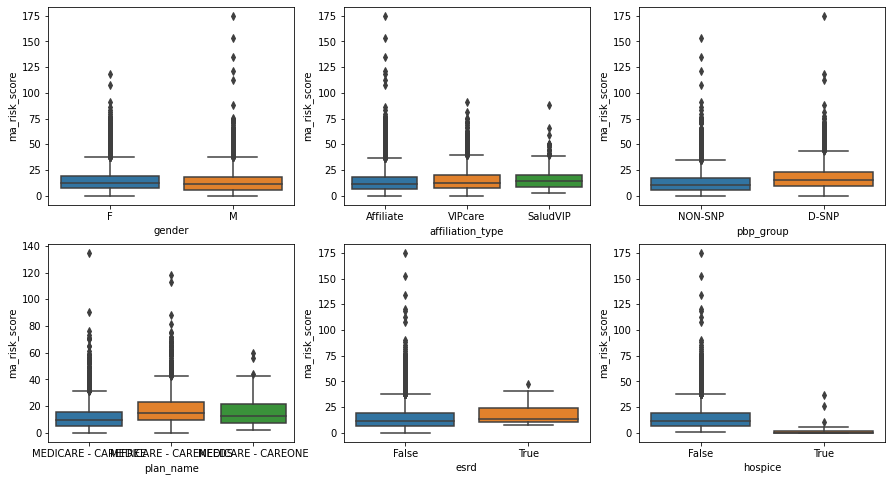

In [30]:
finance_feature = 'ma_risk_score'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for idx, feature in enumerate(cat_features):
    sns.boxplot(x=data[feature], y=data[finance_feature], ax=axes[idx //3, idx % 3]);

There is no significant difference in the distributions by category.

### 4.4. mbr_with_rx_rebates

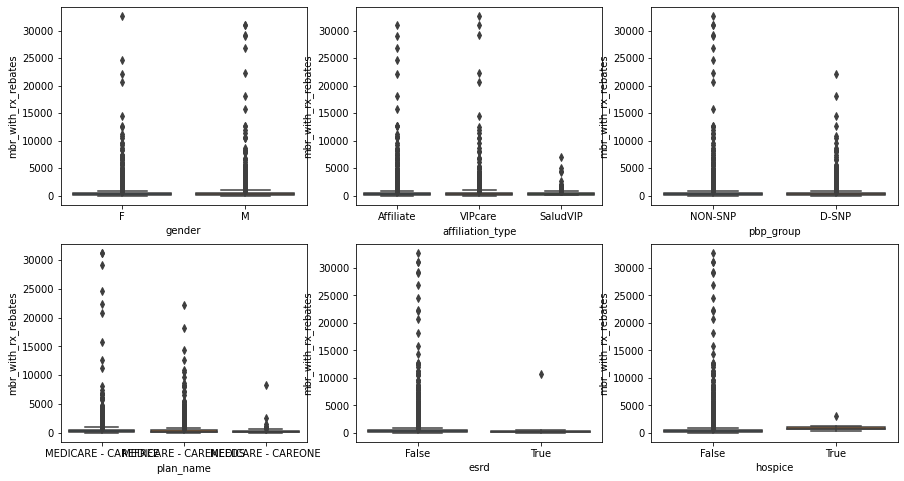

In [31]:
finance_feature = 'mbr_with_rx_rebates'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for idx, feature in enumerate(cat_features):
    sns.boxplot(x=data[feature], y=data[finance_feature], ax=axes[idx //3, idx % 3]);

There is no significant difference in the distributions by category.

### 4.5. partd_premium

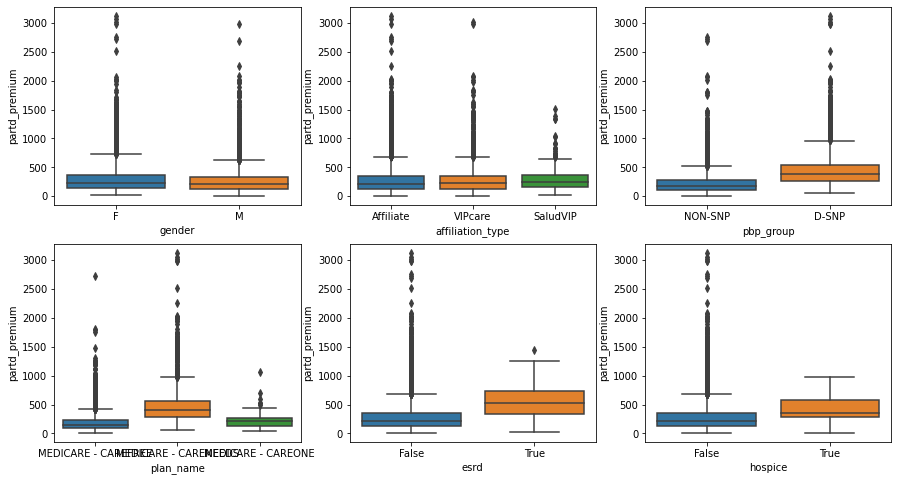

In [32]:
finance_feature = 'partd_premium'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for idx, feature in enumerate(cat_features):
    sns.boxplot(x=data[feature], y=data[finance_feature], ax=axes[idx //3, idx % 3]);

**partd_premium vs. esrd**

In [33]:
stats.ttest_ind\
(data[data['esrd']  == True]['partd_premium'], data[data['esrd']  == False]['partd_premium'], equal_var = False)

Ttest_indResult(statistic=4.899393909506256, pvalue=4.353899883243275e-05)

The hypothesis of equality of means is not confirmed.

### 4.6. pcp_cap

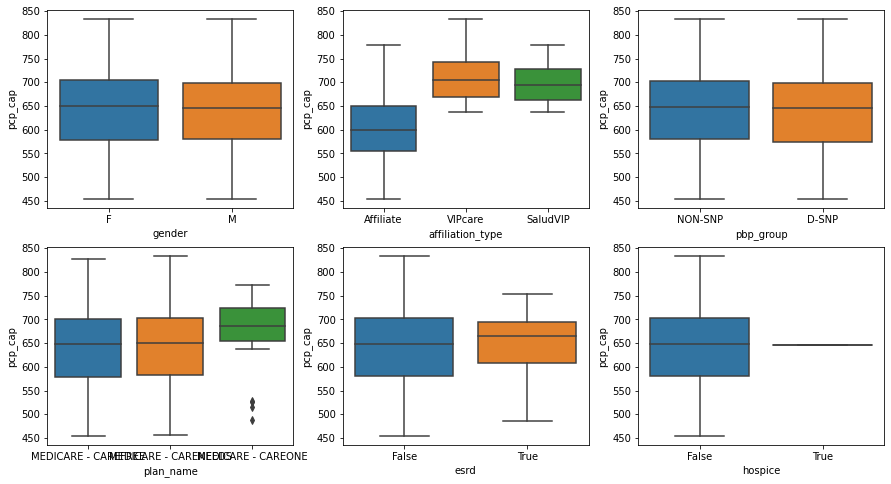

In [34]:
finance_feature = 'pcp_cap'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for idx, feature in enumerate(cat_features):
    sns.boxplot(x=data[feature], y=data[finance_feature][data[finance_feature]!=0], ax=axes[idx //3, idx % 3]);

There is no significant difference in the distributions by category.

### 4.7. pcp_ffs

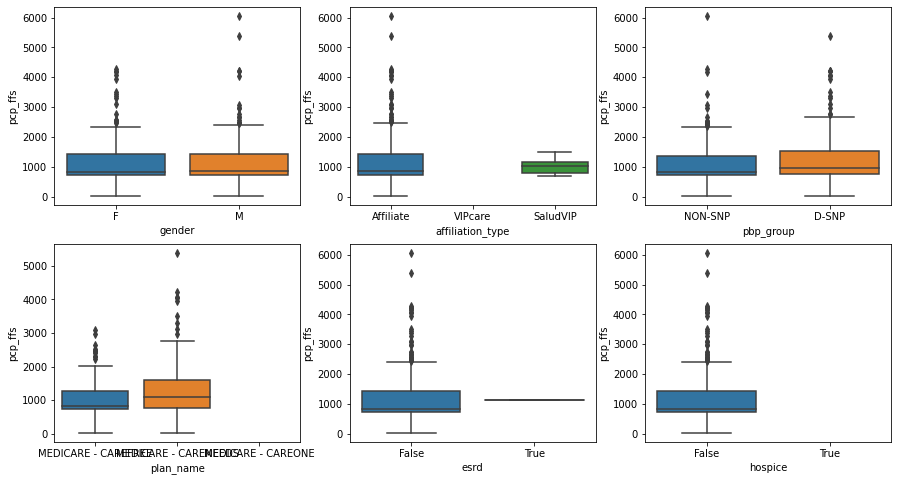

In [35]:
finance_feature = 'pcp_ffs'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
for idx, feature in enumerate(cat_features):
    sns.boxplot(x=data[feature], y=data[finance_feature][data[finance_feature]!=0], ax=axes[idx //3, idx % 3]);

There is no significant difference in the distributions by category.

### 4.8.  plan_premium

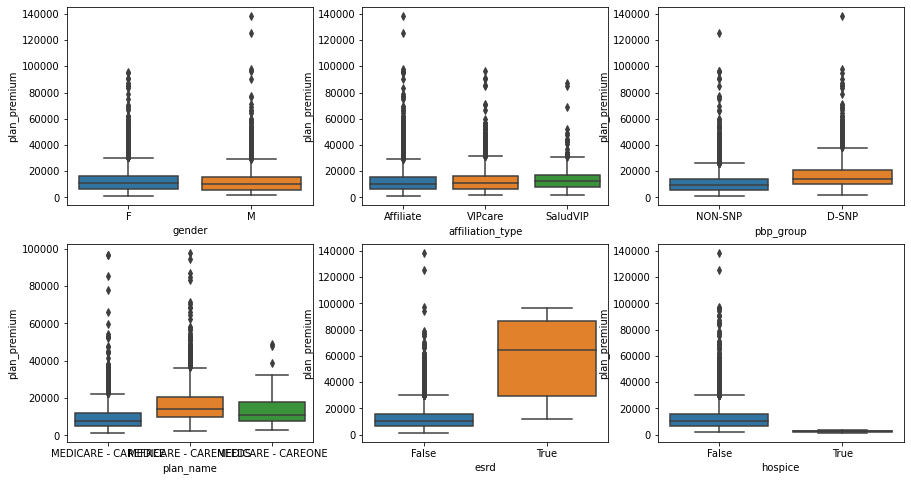

In [36]:
finance_feature = 'plan_premium'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for idx, feature in enumerate(cat_features):
    sns.boxplot(x=data[feature], y=data[finance_feature], ax=axes[idx //3, idx % 3]);

**plan_premium vs. esrd**

In [37]:
stats.ttest_ind\
(data[data['esrd']  == True]['plan_premium'], data[data['esrd']  == False]['plan_premium'], equal_var = False)

Ttest_indResult(statistic=7.8368680865668106, pvalue=2.5896578603052367e-08)

The hypothesis of equality of means is not confirmed.

### 4.9.  prof

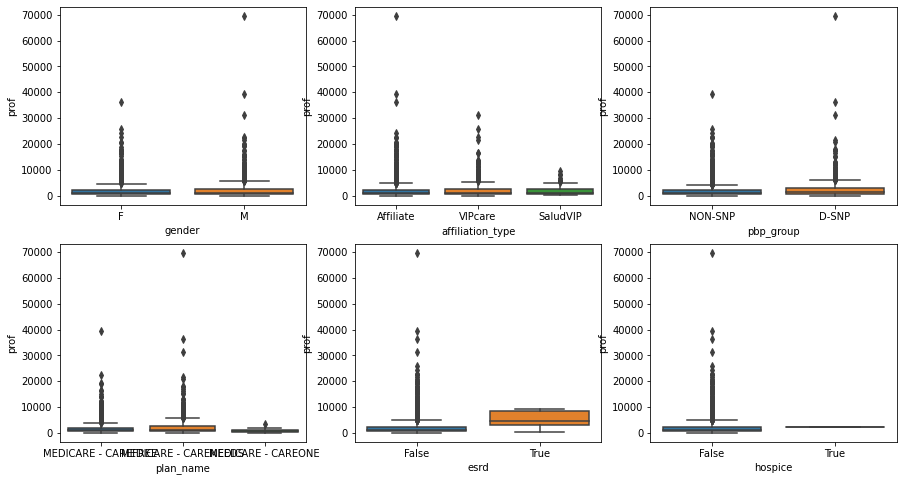

In [38]:
finance_feature = 'prof'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for idx, feature in enumerate(cat_features):
    sns.boxplot(x=data[feature], y=data[finance_feature][data[finance_feature]!=0], ax=axes[idx //3, idx % 3]);

**prof vs. esrd**

In [39]:
stats.ttest_ind\
(data[data['esrd']  == True]['prof'], data[data['esrd']  == False]['prof'], equal_var = False)

Ttest_indResult(statistic=2.1437889267363683, pvalue=0.04155649466098429)

The hypothesis of equality of means is not confirmed.

### 4.10.  reinsurance

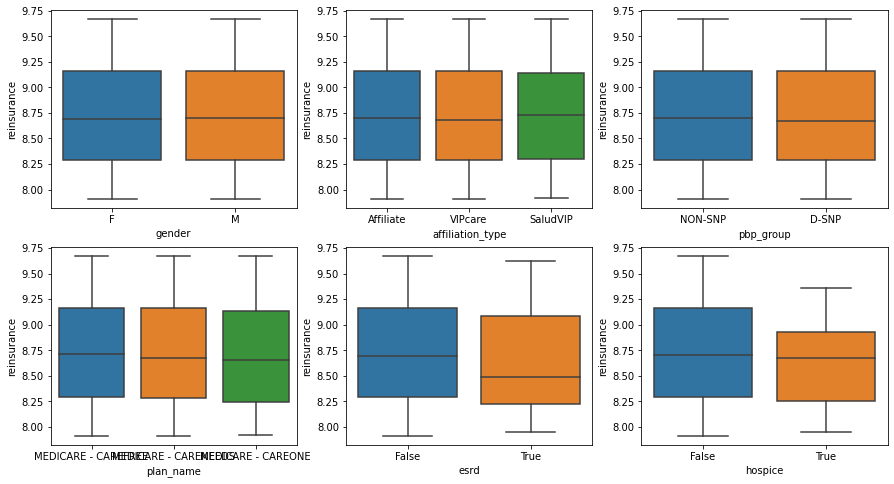

In [40]:
finance_feature = 'reinsurance'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for idx, feature in enumerate(cat_features):
    sns.boxplot(x=data[feature], y=data[finance_feature], ax=axes[idx //3, idx % 3]);

There is no significant difference in the distributions by category.

### 4.11.  rx

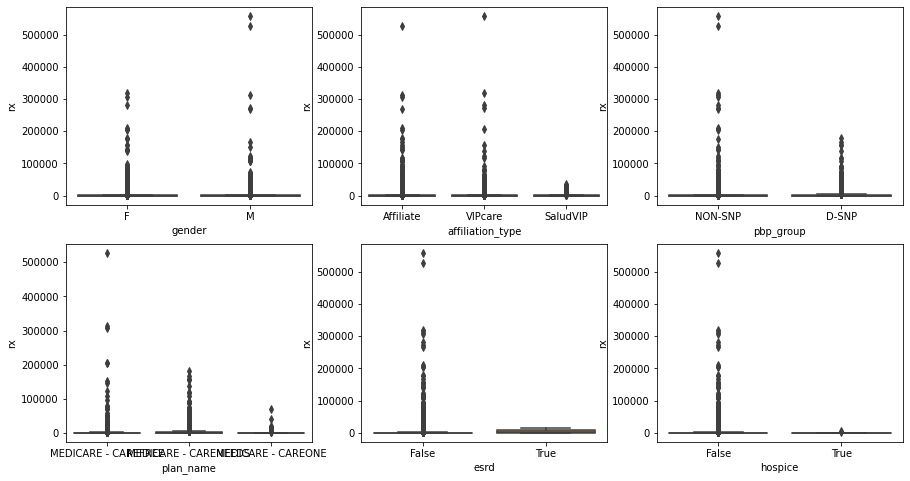

In [41]:
finance_feature = 'rx'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for idx, feature in enumerate(cat_features):
    sns.boxplot(x=data[feature], y=data[finance_feature][data[finance_feature]!=0], ax=axes[idx //3, idx % 3]);

**esrd**

In [42]:
stats.ttest_ind\
(data[data['esrd']  == True]['rx'], data[data['esrd']  == False]['rx'], equal_var = False)

Ttest_indResult(statistic=2.749846044967434, pvalue=0.0105249922570915)

The hypothesis of equality of means is not confirmed.

### 4.12.  rx_with_rebates

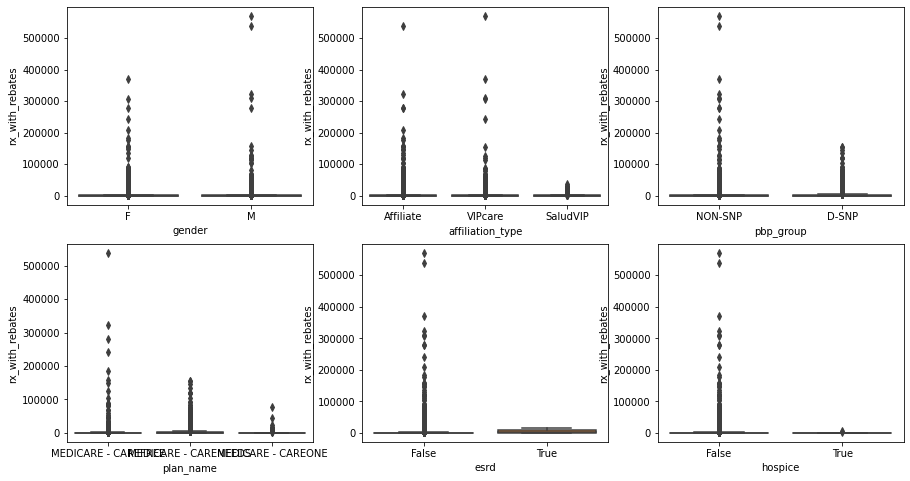

In [43]:
finance_feature = 'rx_with_rebates'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for idx, feature in enumerate(cat_features):
    sns.boxplot(x=data[feature], y=data[finance_feature][data[finance_feature]!=0], ax=axes[idx //3, idx % 3]);

**rx_with_rebates vs. esrd**

In [44]:
stats.ttest_ind\
(data[data['esrd']  == True]['rx_with_rebates'], data[data['esrd']  == False]['rx_with_rebates'], \
 equal_var = False)

Ttest_indResult(statistic=2.731303675191307, pvalue=0.01098639254599894)

The hypothesis of equality of means is not confirmed.

### 4.13.  rx_without_rebates

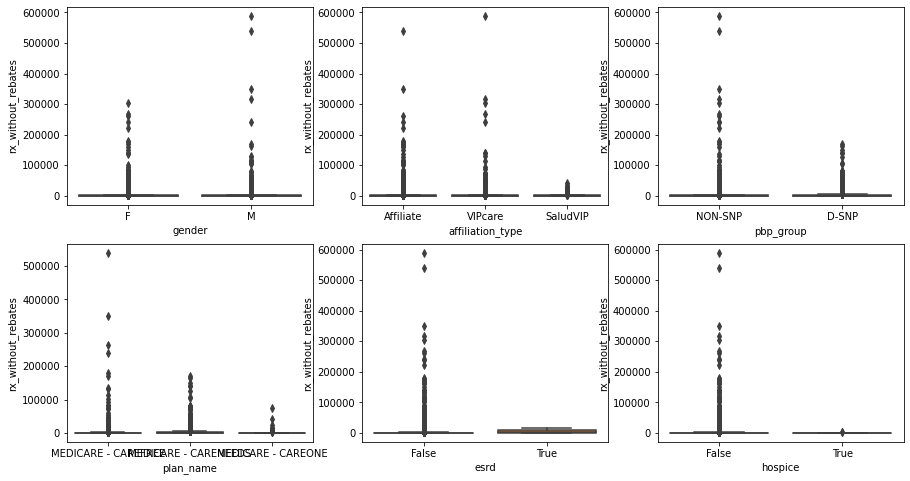

In [45]:
finance_feature = 'rx_without_rebates'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for idx, feature in enumerate(cat_features):
    sns.boxplot(x=data[feature], y=data[finance_feature][data[finance_feature]!=0], ax=axes[idx //3, idx % 3]);

**rx_without_rebates vs. esrd**

In [46]:
stats.ttest_ind\
(data[data['esrd']  == True]['rx_without_rebates'], data[data['esrd']  == False]['rx_without_rebates'], \
 equal_var = False)

Ttest_indResult(statistic=2.8081370126065472, pvalue=0.009151413110514367)

The hypothesis of equality of means is not confirmed.

### 4.14.  spec_cap

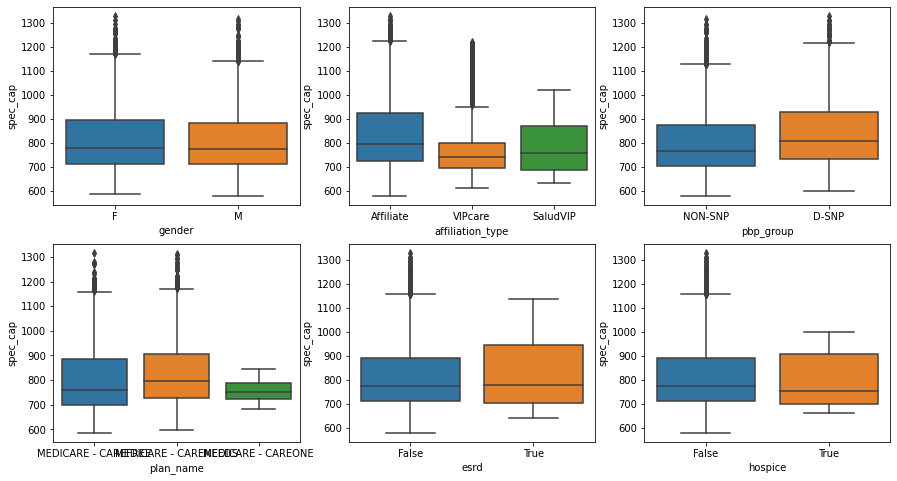

In [47]:
finance_feature = 'spec_cap'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for idx, feature in enumerate(cat_features):
    sns.boxplot(x=data[feature], y=data[finance_feature], ax=axes[idx //3, idx % 3]);

There is no significant difference in the distributions by category.

Previous analysis showed that being on dialysis (*esrd*) significantly affects (increases the central mean trend, which seems logical) in the distribution of the following financial indicators: 
- ipa_funding,
- ma_premium,
- partd_premium,
- plan_premium
- prof
- rx
- rx_with_rebates
- rx_without_rebates

We will take this into account when looking for outliers.

## 5. Outliers detection

The distribution of 8 out of 14 financial features is influenced by the presence of the patient on dialysis. To search for further outliers, we can:
1. Select 3 groups
 - features unaffected by dialysis
 - features affected by dialysis, esrd=False
 - features affected by dialysis, esrd=True
2. Divide all features into 2 groups:
 - esrd=False
 - esrd=True

The second option is easier to implement and in fact does not affect the result.

In [48]:
data1 = data.loc[data['esrd']==False]
data2 = data.loc[data['esrd']==True]

Let's consider the 3 most popular algorithms for detecting outliers:
1. z-statistics (based on mean calculation)
2. robust z-statistics (based on median)
3. IQR method (based on 1 and 3 quartiles)

We will try all three methods and choose the most suitable one.

### 5.1.  Patient is not on dialysis

**Initial distribution**

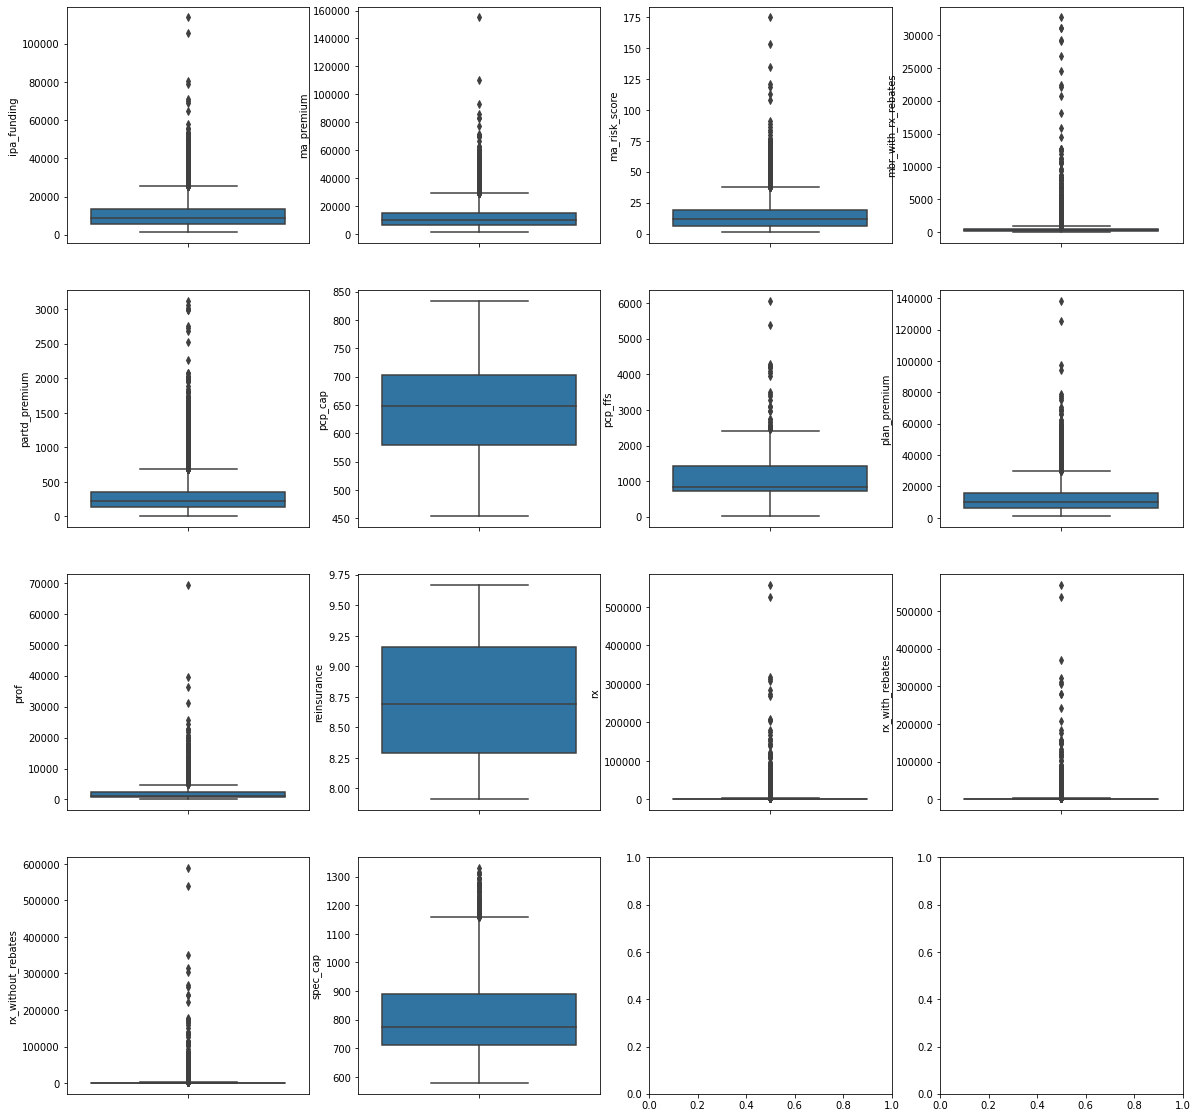

In [49]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
for idx, feature in enumerate(finance_features):
    sns.boxplot(y=data1[feature][data1[feature]!=0], orient='v', ax=axes[idx //4, idx % 4]);

**z-statistics**

% of detected outliers by feature: 

2.0 %
2.0 %
2.0 %
1.0 %
2.0 %
No outliers detected:  pcp_cap
2.0 %
2.0 %
2.0 %
No outliers detected:  reinsurance
1.0 %
1.0 %
1.0 %
0.0 %
CPU times: user 41.9 s, sys: 673 ms, total: 42.6 s
Wall time: 43.2 s


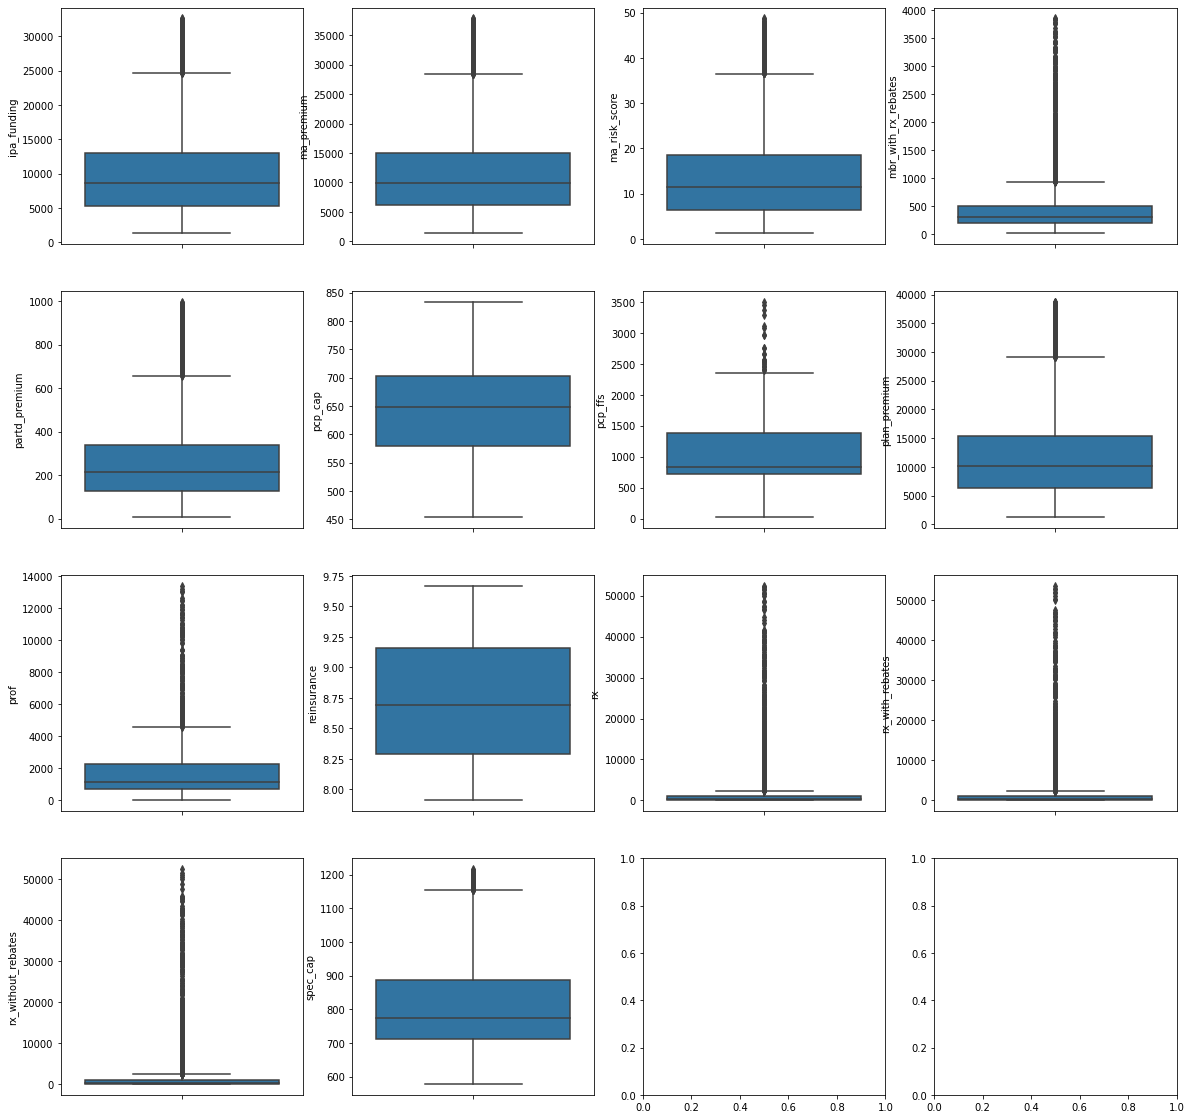

In [50]:
%%time
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
print('% of detected outliers by feature: \n')
for idx, feature in enumerate(finance_features):
    try:
        sns.boxplot\
        (y=data1[feature][(data1[feature]!=0)&(data1[feature]< z_outs(data1[data1[feature]!=0][feature]))], \
         orient='v', ax=axes[idx //4, idx % 4]);       
    except ValueError:
        print('No outliers detected: ', feature)
        sns.boxplot(y=data1[data1[feature]!=0][feature], orient='v', ax=axes[idx //4, idx % 4]);
        continue

**Robust z-statistics**

% of detected outliers by feature: 

1.0 %
2.0 %
1.0 %
5.0 %
2.0 %
No outliers detected:  pcp_cap
4.0 %
2.0 %
9.0 %
No outliers detected:  reinsurance
19.0 %
19.0 %
19.0 %
0.0 %
CPU times: user 1min 35s, sys: 1.13 s, total: 1min 37s
Wall time: 1min 38s


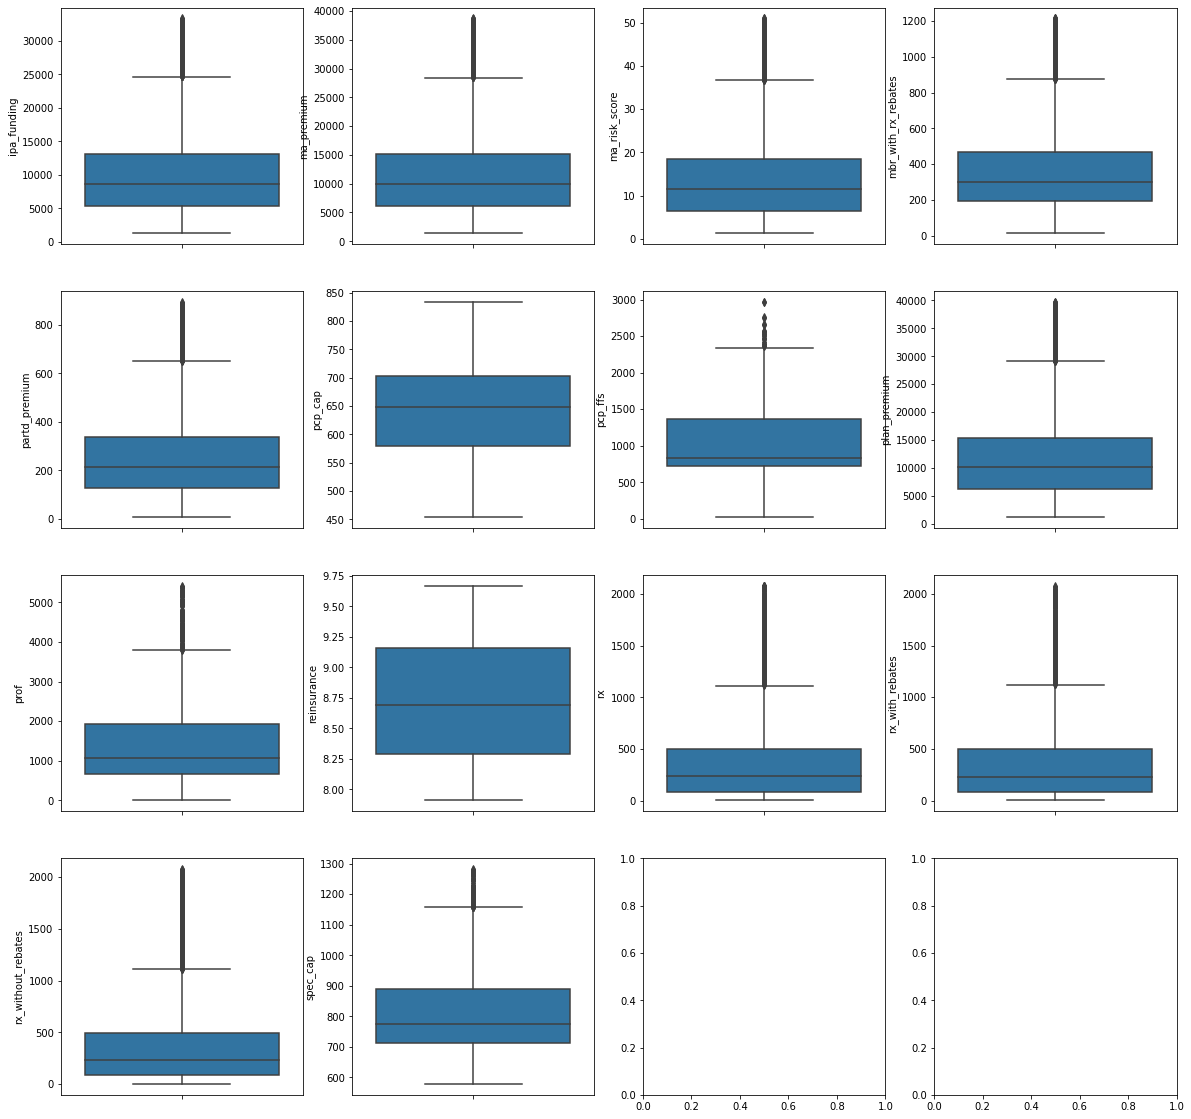

In [51]:
%%time
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
print('% of detected outliers by feature: \n')
for idx, feature in enumerate(finance_features):
    try:
        sns.boxplot\
        (y=data1[feature][(data1[feature]!=0)&(data1[feature]< robust_z_outs(data1[data1[feature]!=0][feature]))], \
         orient='v', ax=axes[idx //4, idx % 4]);        
    except ValueError:
        print('No outliers detected: ', feature)
        sns.boxplot(y=data1[data1[feature]!=0][feature], orient='v', ax=axes[idx //4, idx % 4]);
        continue

**IQR method**

% of detected outliers by feature: 

4.0 %
4.0 %
4.0 %
7.000000000000001 %
5.0 %
No outliers detected:  pcp_cap
8.0 %
4.0 %
11.0 %
No outliers detected:  reinsurance
18.0 %
18.0 %
18.0 %
2.0 %
CPU times: user 4min 42s, sys: 2.79 s, total: 4min 45s
Wall time: 4min 50s


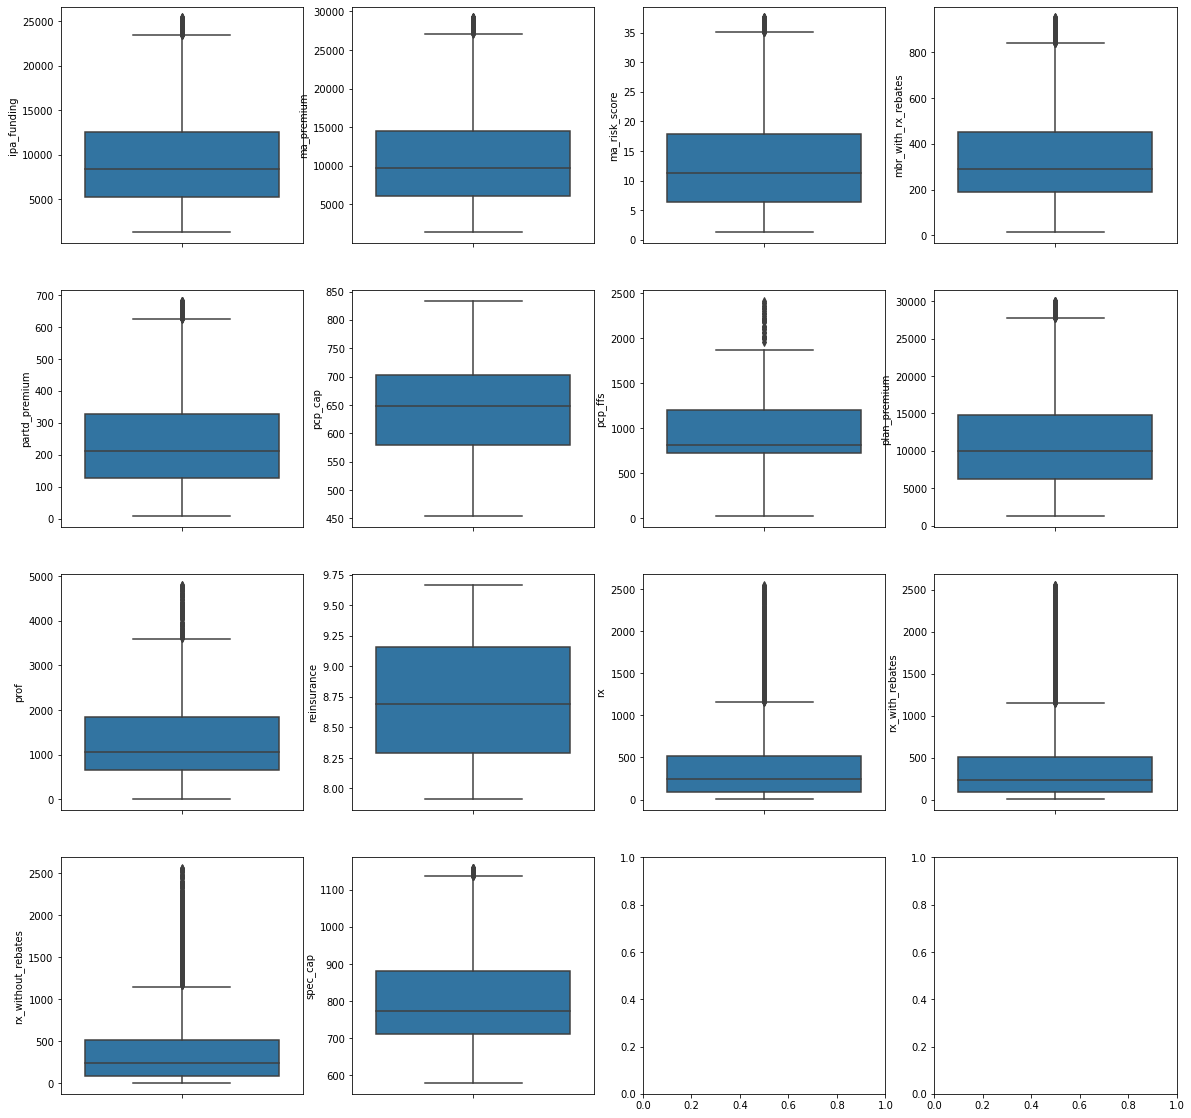

In [52]:
%%time
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
print('% of detected outliers by feature: \n')
for idx, feature in enumerate(finance_features):
    try:
        sns.boxplot\
        (y=data1[feature][(data1[feature]!=0)&(data1[feature]< iqr_outs(data1[data1[feature]!=0][feature]))], \
         orient='v', ax=axes[idx //4, idx % 4]);      
    except ValueError:
        print('No outliers detected: ', feature)
        sns.boxplot(y=data1[data1[feature]!=0][feature], orient='v', ax=axes[idx //4, idx % 4]);
        continue

### 5.2.  Patient is on dialysis

**Initial distribution**

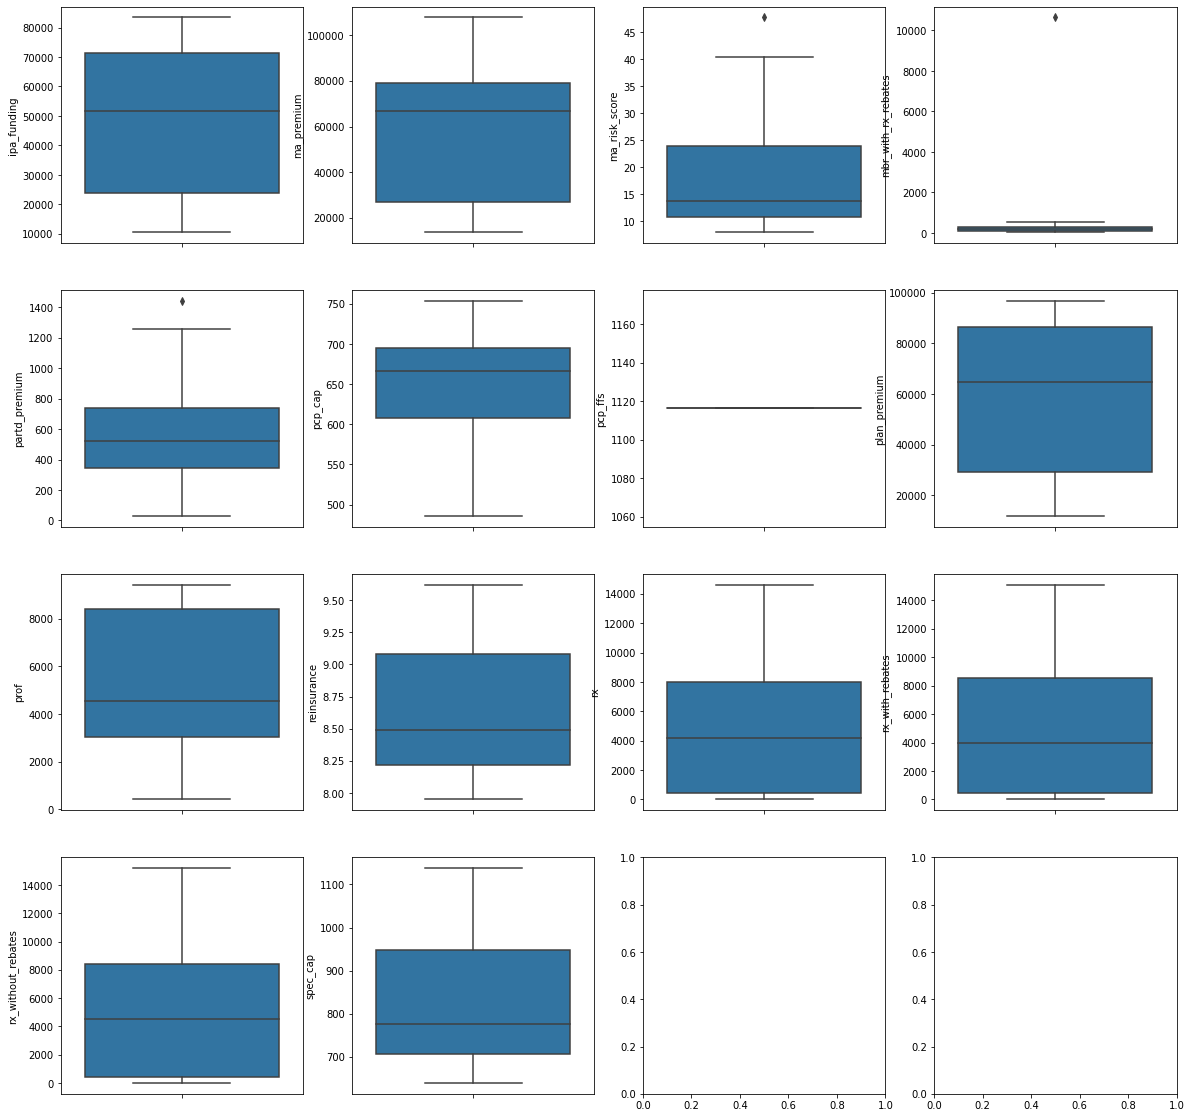

In [53]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
for idx, feature in enumerate(finance_features):
    sns.boxplot(y=data2[feature][data2[feature]!=0], orient='v', ax=axes[idx //4, idx % 4]);

In this case, there are practically no outliers. Perhaps there was very little data. Let's see if the algorithms find anything.

**z-statistics**

% of detected outliers by feature: 

No outliers detected:  ipa_funding
No outliers detected:  ma_premium
No outliers detected:  ma_risk_score
4.0 %
No outliers detected:  partd_premium
No outliers detected:  pcp_cap
No outliers detected:  pcp_ffs
No outliers detected:  plan_premium
No outliers detected:  prof
No outliers detected:  reinsurance
No outliers detected:  rx
No outliers detected:  rx_with_rebates
No outliers detected:  rx_without_rebates
No outliers detected:  spec_cap
CPU times: user 496 ms, sys: 22.6 ms, total: 518 ms
Wall time: 506 ms


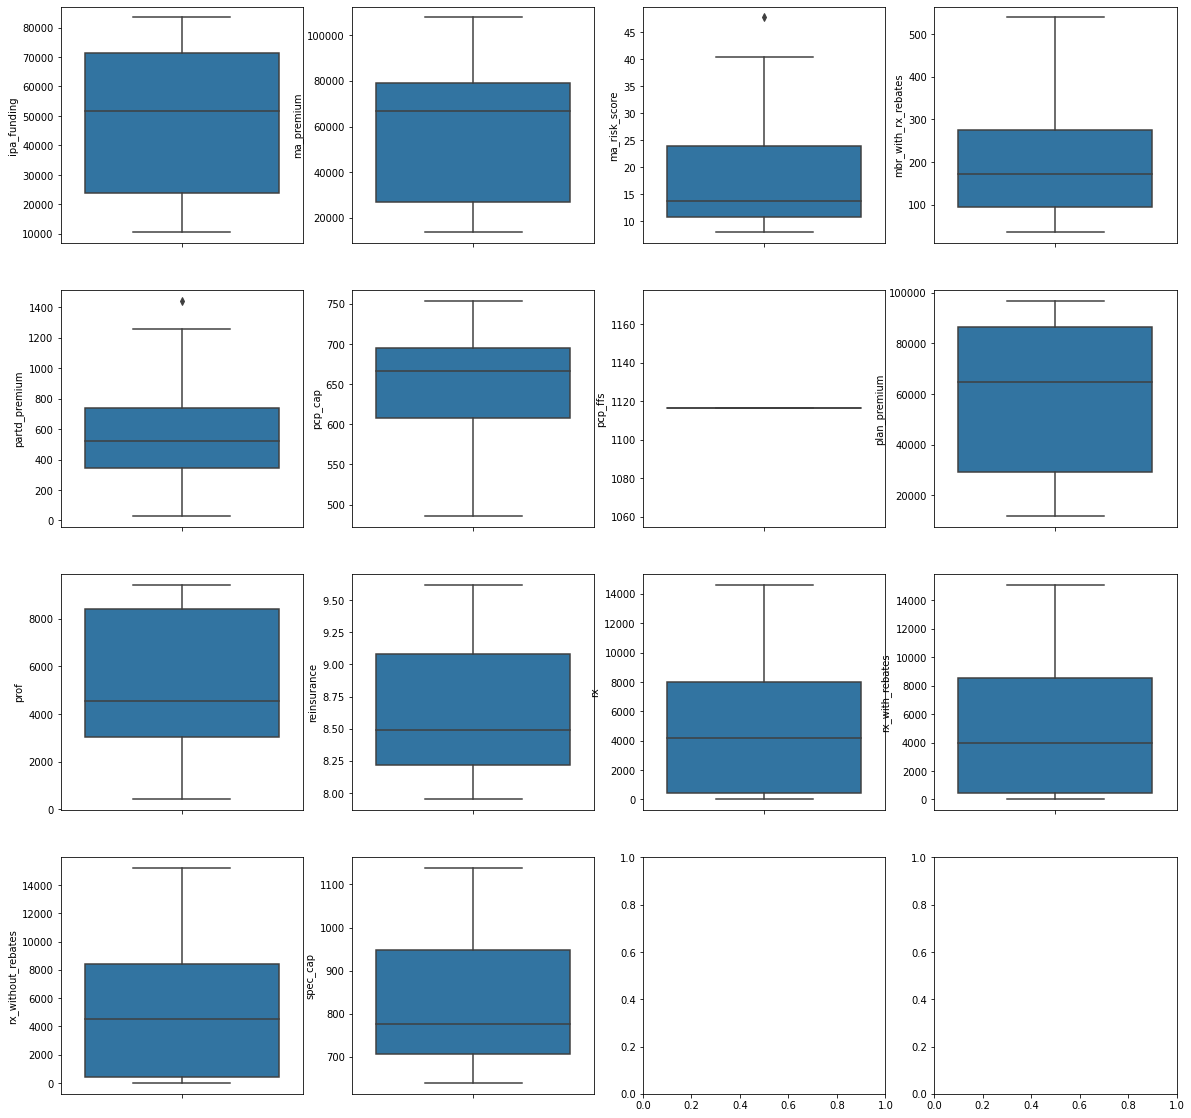

In [54]:
%%time
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
print('% of detected outliers by feature: \n')
for idx, feature in enumerate(finance_features):
    try:
        sns.boxplot\
        (y=data2[feature][(data2[feature]!=0)&(data2[feature]< z_outs(data2[data2[feature]!=0][feature]))], \
         orient='v', ax=axes[idx //4, idx % 4]);        
    except ValueError:
        print('No outliers detected: ', feature)
        sns.boxplot(y=data2[data2[feature]!=0][feature], orient='v', ax=axes[idx //4, idx % 4]);
        continue

**Robust z-statistics**

% of detected outliers by feature: 

No outliers detected:  ipa_funding
No outliers detected:  ma_premium
7.000000000000001 %
4.0 %
No outliers detected:  partd_premium
No outliers detected:  pcp_cap
No outliers detected:  pcp_ffs
No outliers detected:  plan_premium
No outliers detected:  prof
No outliers detected:  reinsurance
No outliers detected:  rx
No outliers detected:  rx_with_rebates
No outliers detected:  rx_without_rebates
No outliers detected:  spec_cap
CPU times: user 683 ms, sys: 28.3 ms, total: 712 ms
Wall time: 712 ms


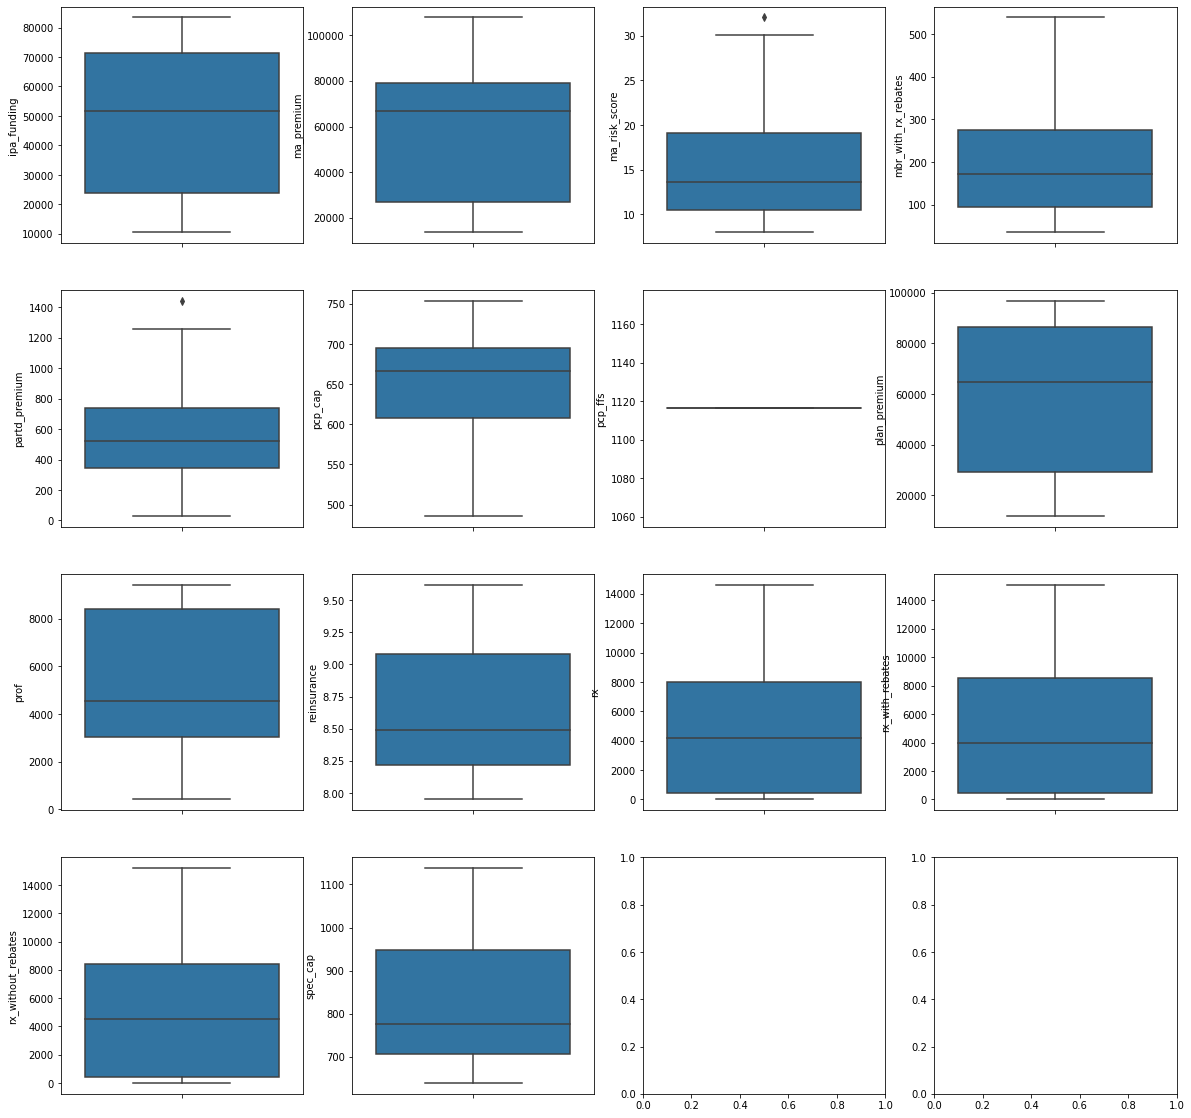

In [55]:
%%time
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
print('% of detected outliers by feature: \n')
for idx, feature in enumerate(finance_features):
    try:
        sns.boxplot\
        (y=data2[feature][(data2[feature]!=0)&(data2[feature]< robust_z_outs(data2[data2[feature]!=0][feature]))], \
         orient='v', ax=axes[idx //4, idx % 4]);       
    except ValueError:
        print('No outliers detected: ', feature)
        sns.boxplot(y=data2[data2[feature]!=0][feature], orient='v', ax=axes[idx //4, idx % 4]);
        continue

**IQR method**

% of detected outliers by feature: 

No outliers detected:  ipa_funding
No outliers detected:  ma_premium
4.0 %
4.0 %
4.0 %
No outliers detected:  pcp_cap
No outliers detected:  pcp_ffs
No outliers detected:  plan_premium
No outliers detected:  prof
No outliers detected:  reinsurance
No outliers detected:  rx
No outliers detected:  rx_with_rebates
No outliers detected:  rx_without_rebates
No outliers detected:  spec_cap
CPU times: user 1.29 s, sys: 45.4 ms, total: 1.34 s
Wall time: 1.37 s


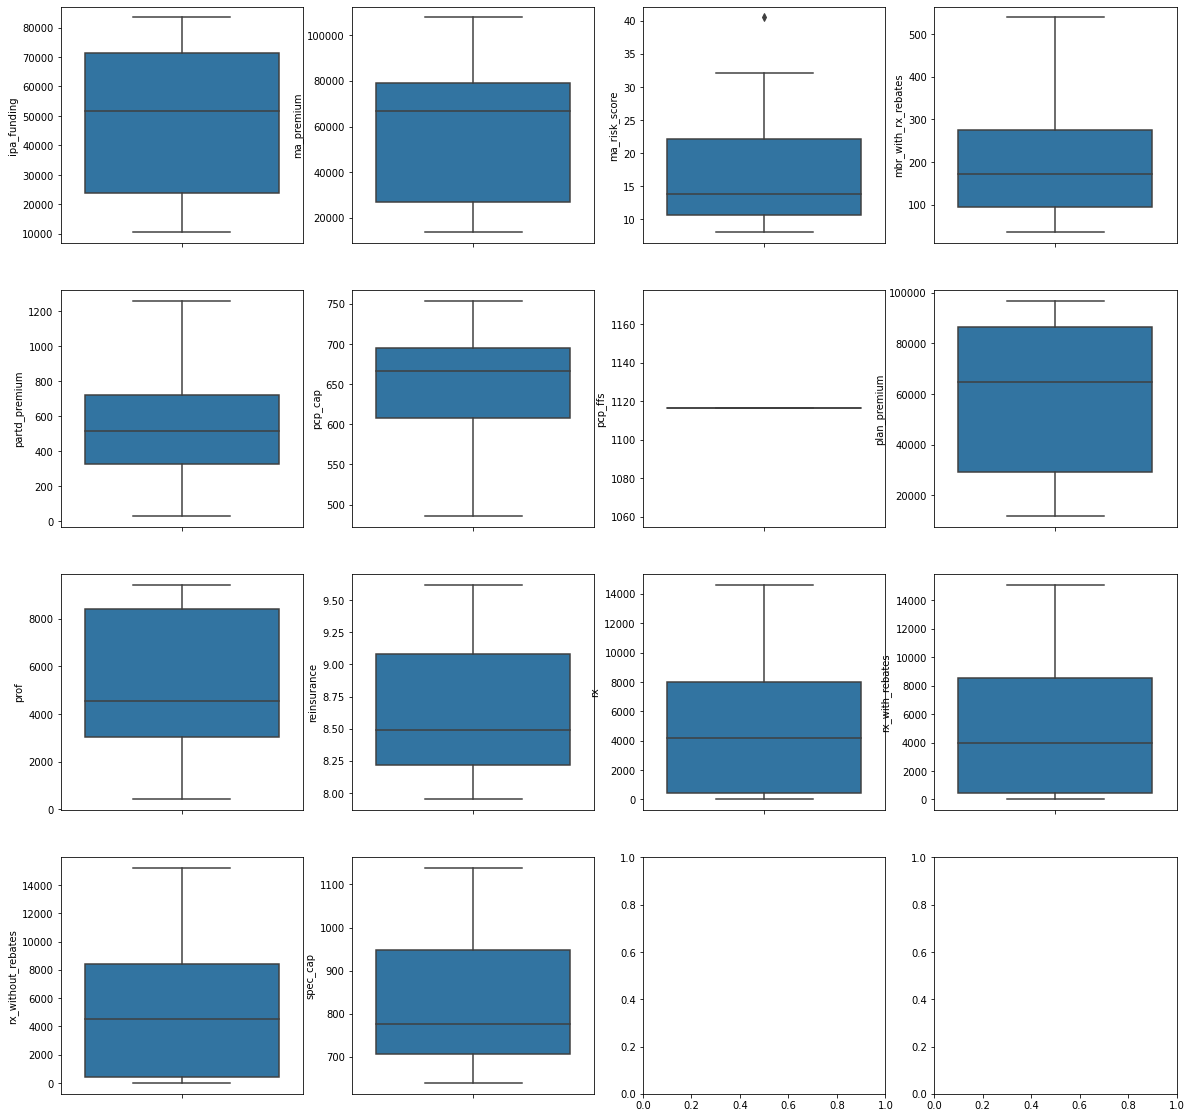

In [56]:
%%time
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
print('% of detected outliers by feature: \n')
for idx, feature in enumerate(finance_features):
    try:
        sns.boxplot\
        (y=data2[feature][(data2[feature]!=0)&(data2[feature]< iqr_outs(data2[data2[feature]!=0][feature]))], \
         orient='v', ax=axes[idx //4, idx % 4]);      
    except ValueError:
        print('No outliers detected: ', feature)
        sns.boxplot(y=data2[data2[feature]!=0][feature], orient='v', ax=axes[idx //4, idx % 4]);
        continue

## 6. Conclusiones

1. The second and third methods are more shown with such a skewed distribution, since they are tied to quartiles, and not to the arithmetic mean like the first method.
2. The quality of robust z-statistic is similar to quality of IQR method in our case, forethemore the IQR method requires more computational load (about 3 times more than robust z-statistic method). Then, the robust z-statistic method would be most suitable for such case.
3. The outliers detection algorithm should be applied separately in each group: dialysis patients and non-dialysis patients.